# Import Packages

In [1]:
# built-in
from datetime import datetime, timedelta
import os.path

# third-party (pip install required)
import matplotlib
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import pandas as pd
from pymodulon.io import load_json_model

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [2]:
PRECISE_PATH = '../../data/precise/'
P1K_PATH = '../../data/precise1k/'
K12_PATH = '../../data/k12_modulome/'
FIG_PATH =  'summarize_dataset_figs'

In [3]:
precise1 = load_json_model(os.path.join(PRECISE_PATH, 'precise.json.gz'))
p1k = load_json_model(os.path.join(P1K_PATH, 'precise1k.json.gz'))
k12 = load_json_model(os.path.join(K12_PATH, 'k12_modulome.json.gz'))

# Dataset Growth

In [9]:
precise_metadata_sorted = precise1.sample_table.sort_values('run_date')
p1k_metadata_sorted = p1k.sample_table.sort_values('run_date')
k12_metadata_sorted = k12.sample_table.sort_values('run_date')

order = pd.DataFrame(precise_metadata_sorted.study.unique(), columns = ['study'])
counts = pd.DataFrame(precise_metadata_sorted.groupby(['study']).count()['condition'])
new_1= order.merge(counts, on = 'study')

order = pd.DataFrame(p1k_metadata_sorted.study.unique(), columns = ['study'])
counts = pd.DataFrame(p1k_metadata_sorted.groupby(['study']).count()['condition'])
new_2 = order.merge(counts, on = 'study')

order = pd.DataFrame(k12_metadata_sorted.study.unique(), columns = ['study'])
counts = pd.DataFrame(k12_metadata_sorted.groupby(['study']).count()['condition'])
new_3 = order.merge(counts, on = 'study')

precise_metadata_sorted["Version"] = "PRECISE"
p1k_metadata_sorted["Version"] = "PRECISE-1K"
k12_metadata_sorted["Version"] = "K-12"

all_df = pd.concat([precise_metadata_sorted, p1k_metadata_sorted, k12_metadata_sorted])
all_df['run_date']= pd.to_datetime(all_df['run_date'])
all_df = all_df.sort_values('run_date')
all_df['Cumulative_Condition_Count'] = [i+1 for i in range(len(all_df))]

p1_cum = []
counter = 0
for i in all_df.Version:
    if i == 'PRECISE':
        counter += 1
    p1_cum.append(counter)
    
all_df["cumulative_P1"] = p1_cum

p1k_cum = []
counter = 0
for i in all_df.Version:
    if i == 'PRECISE-1K':
        counter += 1
    p1k_cum.append(counter)
    
all_df["cumulative_P1K"] = p1k_cum

k12_cum = []
counter = 0
for i in all_df.Version:
    if i == 'K-12':
        counter += 1
    k12_cum.append(counter)
    
all_df["cumulative_K12"] = k12_cum

# # add a dummy row to get to 2021
# all_df = all_df.append({
#     'run_date': datetime(2021,6,1), 'cumulative_P1K': all_df['cumulative_P1K'].max(), 'cumulative_P1': all_df['cumulative_P1'].max()
# }, ignore_index=True)

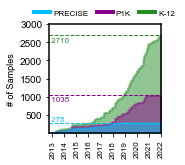

In [10]:
fig, ax = plt.subplots(figsize = (2,2))

k12_col = 'forestgreen'
p1k_col = 'darkmagenta'
p1_col = 'deepskyblue'

ax.set_ylim(0,2800)
ax.set_xlim(min(all_df.run_date), max(all_df.run_date))
plt.fill_between(all_df.run_date, all_df.cumulative_K12, color = k12_col, alpha=0.5, lw=2)
plt.fill_between(all_df.run_date, all_df.cumulative_P1K, color = p1k_col, alpha=0.5,lw=2)
plt.fill_between(all_df.run_date, all_df.cumulative_P1, color = p1_col, alpha=0.5, lw=2)
ax.set_ylabel('# of Samples', fontsize=9)
ax.set_yticks([500, 1000, 1500, 2000, 2500, 3000])
custom_lines = [Line2D([0], [0], color=p1_col, lw=4),
                Line2D([0], [0], color=p1k_col, lw=4),
               Line2D([0], [0], color=k12_col, lw=4)]
name = ['PRECISE', 'P1K', 'K-12']
args = {'handles':custom_lines,'labels':name,'loc':2,'ncol':3,
        'bbox_to_anchor':(-0.2,1.2),'fontsize':8}
ax.legend(**args,  columnspacing=1, handletextpad=.4,
          frameon=False, labelspacing=0.11)

ax.axhline(y=(2710), xmax=1, color =k12_col, linestyle = '--', linewidth = 1)
ax.text(all_df.run_date.iloc[15],2500,s=' 2710', fontsize =8, color =k12_col)
ax.axhline(y=(1035), xmax=1, color =p1k_col, linestyle = '--', linewidth = 1)
ax.text(all_df.run_date.iloc[15],870,s=' 1035', fontsize =8, color =p1k_col)
ax.axhline(y=(278), color =p1_col, linestyle = '--', linewidth = 1)
ax.text(all_df.run_date.iloc[15],310,s=' 278', fontsize =8, color =p1_col)

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.savefig(os.path.join(FIG_PATH, 'dataset_growth.svg'), dpi = 400, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'dataset_growth.png'), dpi = 400, bbox_inches = 'tight')

# Condition Overview

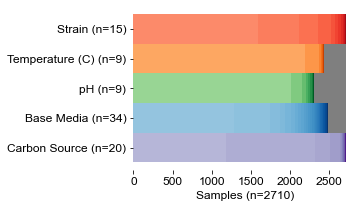

In [8]:
sample_table_for_plot = k12.sample_table.copy()

sample_table_for_plot['Carbon Source'] = sample_table_for_plot['Carbon Source (g/L)'].apply(
    lambda cs: cs.split('(')[0] if pd.notna(cs) else None
)
sample_table_for_plot['Carbon Source'] = sample_table_for_plot['Carbon Source'].fillna('rich')
sample_table_for_plot['Nitrogen Source'] = sample_table_for_plot['Nitrogen Source (g/L)'].apply(
    lambda cs: cs.split('(')[0] if pd.notna(cs) else None
)
sample_table_for_plot['Carbon Source'] = sample_table_for_plot['Carbon Source'].fillna('rich')
sample_table_for_plot['Supplement'] = sample_table_for_plot['Supplement'].apply(
    lambda sup: sup.split('(')[0].strip() if pd.notna(sup) else None
)

n_samples = sample_table_for_plot.shape[0]

_, ax = plt.subplots(figsize=(4, 3))

col_to_cmap = {
    'Strain': 'Reds',
    'Temperature (C)': 'Oranges',
    'pH': 'Greens',
    'Base Media': 'Blues',
    'Carbon Source': 'Purples'
}

labs = []
for i, (col, cmap_for_col) in enumerate(col_to_cmap.items()):

    cmap_to_use = get_cmap(cmap_for_col)
    bottom = 0
    col_counts = sample_table_for_plot[col].value_counts()
    labs.append(f'{col} (n={col_counts.shape[0]})')
    min_col_i, max_col_i = 0.4, 1
    inc = (max_col_i - min_col_i) / col_counts.shape[0]
    for j, (col_val, col_count) in enumerate(col_counts.iteritems()):
        ax.barh(len(col_to_cmap) - i, col_count, left=bottom, height=1, label=col_val, color=cmap_to_use(((min_col_i + j * inc))))
        bottom += col_count
        
    # fill in any remainder with gray
    if bottom < n_samples:
        ax.barh(len(col_to_cmap) - i, n_samples - bottom, left=bottom, height=1, color='tab:gray')

ax.set_xlabel(f'Samples (n={n_samples})', fontsize=12)
ax.set_yticks(range(1, len(col_to_cmap) + 1))
ax.set_yticklabels(labs[::-1])
ax.tick_params(axis='both', labelsize=12)
for s in ax.spines.values():
    s.set_visible(False)
    
plt.savefig(os.path.join(FIG_PATH, 'condition_bars.svg'), dpi = 400, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'condition_bars.png'), dpi = 400, bbox_inches = 'tight')

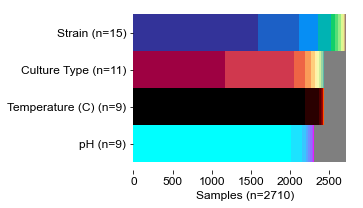

In [12]:
_, ax = plt.subplots(figsize=(4, 3))

col_to_cmap = {
    'Strain': 'terrain',
    'Culture Type': 'Spectral',
    'Temperature (C)': 'gist_heat',
    'pH': 'cool'
}

labs = []
for i, col in enumerate(col_to_cmap.keys()):

    cmap_to_use = get_cmap(col_to_cmap[col])
    bottom = 0
    col_counts = k12.sample_table[col].value_counts()
    labs.append(f'{col} (n={col_counts.shape[0]})')
    for j, (col_val, col_count) in enumerate(col_counts.iteritems()):
        ax.barh(len(col_to_cmap) - i, col_count, left=bottom, height=1, label=col_val, color=cmap_to_use(j/col_counts.shape[0]))
        bottom += col_count
    if bottom < k12.sample_table.shape[0]:
        ax.barh(len(col_to_cmap) - i, k12.sample_table.shape[0] - bottom, height=1, left=bottom, color='tab:grey')

ax.set_xlabel('Samples (n=2710)', fontsize=12)
ax.set_yticks(range(1, len(col_to_cmap) + 1))
ax.set_yticklabels(labs[::-1])
ax.tick_params(axis='both', labelsize=12)
for s in ax.spines.values():
    s.set_visible(False)
    
plt.savefig(os.path.join(FIG_PATH, 'condition_bars.svg'), dpi = 400, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'condition_bars.png'), dpi = 400, bbox_inches = 'tight')